# Манитное склонение

In [1]:
import datetime

def d(year, value, change):
    current_year = datetime.datetime.now().year
    return value + change * (current_year - year)

# Девиация
## Таблица

In [2]:
import pandas as pd

sigma_table = pd.read_csv('deviation.csv', header=None, names=["Compass Course", "Deviation"])
sigma_table

,Compass Course,Deviation
0,0,-2.5
1,10,-0.5
2,20,1.6
3,30,4.4
4,40,7.6
5,50,11.1
6,60,14.0
7,70,16.5
8,80,18.7
9,90,20.1


In [3]:
def _assert_course(course):
    assert course < 360, "Course value should be less than 360 degrees"

def _normalize(course):
    course = course % 360
    if course < 0:
        course = 360 + course
    return round(course, 2)

def deviation_for_cc(compass_course):
    """
    Calculate deviation for the given compass course.

    :param compass_course: in degrees
    :return: deviation rounded to 2 decimal digits
    """
    _assert_course(compass_course)
    cell_index = compass_course // 10
    next_cell_index = (cell_index + 1) % sigma_table.shape[0]
    remainder = compass_course % 10

    sigma = sigma_table.Deviation[cell_index] + (sigma_table.Deviation[next_cell_index] - sigma_table.Deviation[cell_index]) / 10 * remainder
    return sigma

In [4]:
SIGMA = 0.015
MAX_ITERATIONS = 30

def deviation_for_mc(magnetic_course):
    _normalize(magnetic_course)

    # print("Magnetic: {}".format(magnetic_course))
    compass_course = magnetic_course
    last_dev = 360

    for i in range(MAX_ITERATIONS):
        dev = deviation_for_cc(compass_course)

        if abs(last_dev - dev) <= SIGMA:
            return dev

        compass_course = _normalize(magnetic_course + dev)
        last_dev = dev
        # print("Deviation: {} Corrected course: {}".format(dev, compass_course))

    raise Exception("Iteration limit exceeded, but deviation is still not found")

# Графики девиации для компасного и магнитного курсов

Text(0.5, 1.05, 'Deviation for Magnetic Course')

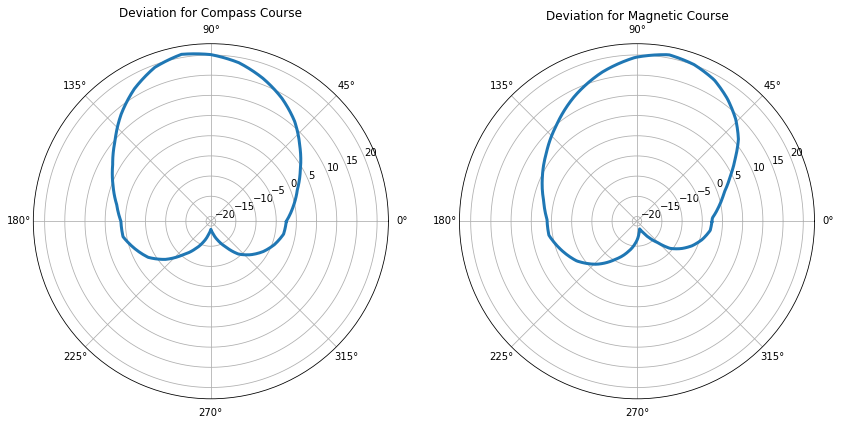

In [5]:
import matplotlib.pyplot as plt
from math import radians

courses = list(range(360))
rad = [radians(x) for x in courses]

ax0 = plt.subplot(121, projection='polar')
ax0.figure.set_size_inches(14, 7)
ax0.plot(rad, [deviation_for_cc(x) for x in courses], linewidth=3.0)
ax0.set_title('Deviation for Compass Course', va='bottom')

ax1 = plt.subplot(122, projection='polar')
ax1.plot(rad, [deviation_for_mc(x) for x in courses], linewidth=3.0)
ax1.set_title('Deviation for Magnetic Course')

In [6]:
def mc_from_cc(compass_course):
    """
    Find magnetic course from compass course.

    :param compass_course: in degrees
    :return: magnetic course
    """
    sigma = deviation_for_cc(compass_course)
    return _normalize(compass_course + sigma)

def cc_from_mc(magnetic_course):
    """
    Find compass course from magnetic course.

    :param magnetic_course: in degrees
    :return: compass course
    """
    sigma = deviation_for_mc(magnetic_course)
    return _normalize(magnetic_course - sigma)

# Прямая задача – Расчет истинного курса по компасному

In [7]:
YEAR = 2006
VALUE = 1.6
CHANGE = 0.2

COMPASS_COURSE = 0

dev = d(YEAR, VALUE, CHANGE)

true_course = mc_from_cc(COMPASS_COURSE) + dev
true_course

361.9

# Обратная задача – Расчет компасного курса по истинному

In [8]:
YEAR = 2006
VALUE = 1.6
CHANGE = 0.2

TRUE_COURSE = 10

dev = d(YEAR, VALUE, CHANGE)

compass_course = cc_from_mc(_normalize(TRUE_COURSE - dev))
compass_course

7.32

In [9]:
# Check for all compass courses
for x in [x / 10 for x in range(0, 3600, 1)]:
    cc_0 = x
    sigma_cc = deviation_for_cc(cc_0)
    mc_0 = _normalize(cc_0 - sigma_cc)
    sigma_mc = deviation_for_mc(mc_0)
    cc_1 = _normalize(mc_0 + sigma_mc)

    # print(cc_0, mc_0, sigma_cc, sigma_mc)

    assert abs(cc_1 - cc_0) < 0.1, \
        "Original CC is {}, but recalculated is {}".format(cc_0, cc_1)

In [10]:
# Check for all magnetic courses
for x in [x / 10 for x in range(0, 3600, 1)]:
    mc_0 = x
    sigma_mc = deviation_for_mc(mc_0)
    cc_0 = _normalize(mc_0 + sigma_mc)
    sigma_cc = deviation_for_cc(cc_0)
    mc_1 = _normalize(cc_0 - sigma_cc)

    # print(cc_0, mc_0, sigma_cc, sigma_mc)

    assert abs(mc_1 - mc_0) < 0.1, \
        "Original MC is {}, but recalculated is {}".format(mc_0, mc_1)

# Девиация по компасному курсу

In [11]:
def get_input_stub():
    return 0

def get_input():
    """
    Use in cases when input messaging is implemented but widgets are not.
    """
    return _normalize(int(input()))

In [12]:
COMPASS_COURSE = get_input_stub()

deviation_for_cc(COMPASS_COURSE)

-2.5

# Девиация по магнитному курсу

In [13]:
MAGNETIC_COURSE = get_input_stub()

deviation_for_mc(MAGNETIC_COURSE)

-2.604000000000001

# Девиация по компасному курсу

In [ ]:
from ipywidgets import interact

def get_input_with_widgets():
    import ipywidgets as widgets
    from IPython.display import display

    a = widgets.FloatText()
    b = widgets.FloatSlider(min=0, max=360)

    display(a)
    widgets.jslink((a, 'value'), (b, 'value'))

    return b

@interact(compass_course=get_input_with_widgets(), )
def interactive_deviation_for_cc(compass_course):
    return round(deviation_for_cc(_normalize(compass_course)), 2)

FloatText(value=0.0)

interactive(children=(FloatSlider(value=0.0, description='compass_course', max=360.0), Output()), _dom_classes…

# Девиация по магнитному курсу

In [15]:
@interact(magnetic_course=get_input_with_widgets())
def interactive_deviation_for_mc(magnetic_course):
    return round(deviation_for_mc(_normalize(magnetic_course)), 2)


FloatText(value=0.0)

interactive(children=(FloatSlider(value=0.0, description='magnetic_course', max=360.0), Output()), _dom_classe…

In [123]:
@interact(magnetic_course=get_input_with_widgets())
def interactive_deviation_for_mc(magnetic_course):
    return round(deviation_for_mc(_normalize(magnetic_course)), 2)


-2.5

# Девиация по магнитному курсу

In [124]:
MAGNETIC_COURSE = get_input_stub()

deviation_for_mc(MAGNETIC_COURSE)

-2.604000000000001

# Девиация по компасному курсу

In [125]:
from ipywidgets import interact

def get_input_with_widgets():
    import ipywidgets as widgets
    from IPython.display import display

    a = widgets.FloatText()
    b = widgets.FloatSlider(min=0, max=360)

    display(a)
    widgets.jslink((a, 'value'), (b, 'value'))

    return b

@interact(compass_course=get_input_with_widgets(), )
def interactive_deviation_for_cc(compass_course):
    return round(deviation_for_cc(_normalize(compass_course)), 2)

FloatText(value=0.0)

interactive(children=(FloatSlider(value=0.0, description='compass_course', max=360.0), Output()), _dom_classes…

# Девиация по магнитному курсу

In [126]:
@interact(magnetic_course=get_input_with_widgets())
def interactive_deviation_for_mc(magnetic_course):
    return round(deviation_for_mc(_normalize(magnetic_course)), 2)


FloatText(value=0.0)

interactive(children=(FloatSlider(value=0.0, description='magnetic_course', max=360.0), Output()), _dom_classe…